Raw shape: (69, 2, 748, 748)
Volume shape: (69, 748, 748)


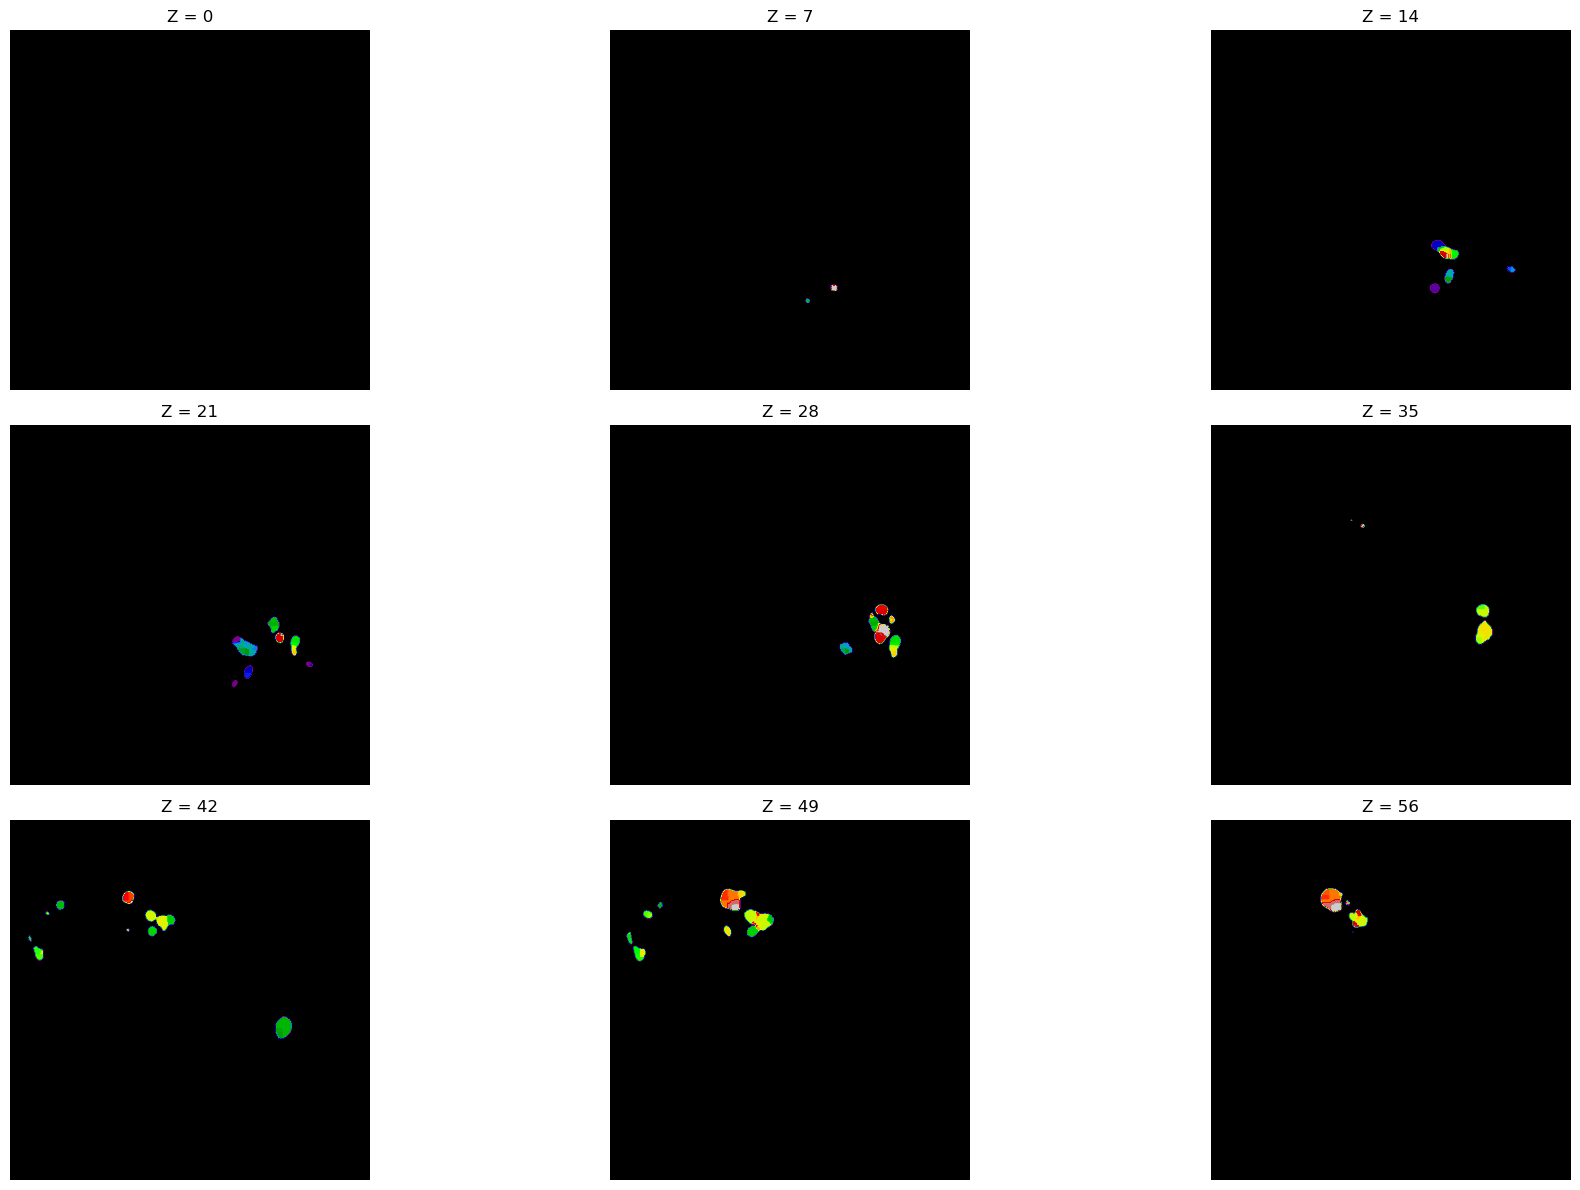

Exported segmentation and region data.
   label  volume          Z           Y           X
0      1   284.0   5.890845  561.757042  410.507042
1      2  3902.0  14.188365  536.172988  464.848795
2      3  3561.0  15.308340  445.499579  470.077225
3      4   880.0  16.735227  495.773864  619.243182
4      5   740.0  16.345946  497.781081  626.312162
✅ All segmentation results saved.
🗜️  All results zipped into: segmentation_results.zip


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt, label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.morphology import remove_small_objects
from tifffile import imread, imwrite
from skimage.measure import regionprops_table
from matplotlib import cm
from skimage.draw import rectangle_perimeter
import pandas as pd
import imageio
import os

# ==== Load Image ====
img = "C://Users//nahue//Downloads//Airy scan_40A_UAS-TMEM-HA_CB_4h_1_051222.tif"
volume_raw = imread(img)
print("Raw shape:", volume_raw.shape)

# ==== Select Channel ====
volume = volume_raw[:, 0, :, :]  # Select first channel
print("Volume shape:", volume.shape)

# ==== Preprocess ====
volume = (volume - volume.min()) / (volume.max() - volume.min())
thresh = threshold_otsu(volume)
binary = volume > thresh
binary = remove_small_objects(binary, min_size=200)

# ==== Segmentation ====
distance = distance_transform_edt(binary)
coords = peak_local_max(distance, labels=binary, footprint=np.ones((3, 3, 3)), exclude_border=False)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = label(mask)
labels_ws = watershed(-distance, markers, mask=binary)

# ==== Visualization ====
fig, axes = plt.subplots(3, 3, figsize=(20, 12))
step = max(1, volume.shape[0] // 9)
for i, ax in enumerate(axes.flat):
    z = i * step
    ax.imshow(labels_ws[z], cmap="nipy_spectral")
    ax.set_title(f"Z = {z}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# ==== Export: Segmentation and Intensity ====
imwrite("segmentation_labels.tif", labels_ws.astype(np.uint16))
imwrite("intensity_volume.tif", (volume * 255).astype(np.uint8))

# ==== Export: Animated GIF ====
frames = [(labels_ws[z] * 10).astype(np.uint8) for z in range(volume.shape[0])]
imageio.mimsave("segmentation_stack.gif", frames, duration=0.1)

# ==== Export: Region Properties ====
props = regionprops_table(labels_ws, properties=['label', 'area', 'centroid'])
df = pd.DataFrame(props)

#Rename columns for clarity
df.rename(columns={
    'area': 'volume',
    'centroid-0': 'Z',
    'centroid-1': 'Y',
    'centroid-2': 'X'
}, inplace=True)

df.to_csv("segmentation_measurements.csv", index=False)
print("Exported segmentation and region data.")
print(df.head())

# ==== Save Each Label Per Z-Slice ====
binary_dir = "segmented_objects"
os.makedirs(binary_dir, exist_ok=True)

for z in range(labels_ws.shape[0]):
    slice_labels = labels_ws[z]
    unique_labels = np.unique(slice_labels)
    unique_labels = unique_labels[unique_labels != 0]  # Exclude background

    for label_val in unique_labels:
        binary_mask = (slice_labels == label_val).astype(np.uint8) * 255
        filename = os.path.join(binary_dir, f"Z{z:02d}_label_{label_val:03d}.tif")
        imwrite(filename, binary_mask)

# ==== Save Color-Coded Labels Per Slice ====
color_output_dir = "segmented_objects_colored"
os.makedirs(color_output_dir, exist_ok=True)

for z in range(labels_ws.shape[0]):
    slice_labels = labels_ws[z]
    unique_labels = np.unique(slice_labels)
    unique_labels = unique_labels[unique_labels != 0]

    for label_val in unique_labels:
        mask = (slice_labels == label_val)
        colored_mask = cm.nipy_spectral(label_val / np.max(labels_ws))[:3]  # RGB
        rgb_image = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for c in range(3):
            rgb_image[..., c] = (mask * 255 * colored_mask[c]).astype(np.uint8)

        filename = os.path.join(color_output_dir, f"Z{z:02d}_label_{label_val:03d}_color.tif")
        imwrite(filename, rgb_image)

# ==== Save Bounding Box Overlays ====
bbox_output_dir = "segmented_objects_bbox"
os.makedirs(bbox_output_dir, exist_ok=True)

for z in range(labels_ws.shape[0]):
    labeled_slice = labels_ws[z]
    #bbox_img = np.zeros_like(labeled_slice, dtype=np.uint8)
    canvas = np.zeros((*labeled_slice.shape, 3), dtype=np.uint8)

    regions = regionprops_table(labeled_slice, properties=['label','bbox','centroid'])
    for i, label_val in enumerate(regions['label']):
        if label_val == 0:
            continue
        minr, minc, maxr, maxc = (
            regions['bbox-0'][i], regions['bbox-1'][i],
            regions['bbox-2'][i], regions['bbox-3'][i]
        )
        #rr, cc = rectangle_perimeter(start=(minr, minc), end=(maxr - 1, maxc - 1), shape=labeled_slice.shape)
        #bbox_img[rr, cc] = 255
        cv2.rectangle(canvas, (minc, minr), (maxc-1, maxr-1), color=(255, 0, 0), thickness=1)

        # Label text near the centroid
        cy, cx = int(regions['centroid-0'][i]), int(regions['centroid-1'][i])
        cv2.putText(canvas, str(label_val), (cx, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

    #filename = os.path.join(bbox_output_dir, f"Z{z:02d}_bbox_overlay.tif")
    #imwrite(filename, bbox_img)
    filename = os.path.join(bbox_output_dir, f"Z{z:02d}_bbox_labels.tif")
    imwrite(filename, canvas)

# ==== Save Full 3D Volumes Per Label ====
volume_output_dir = "label_volumes"
os.makedirs(volume_output_dir, exist_ok=True)

all_labels = np.unique(labels_ws)
all_labels = all_labels[all_labels != 0]

for label_val in all_labels:
    label_volume = (labels_ws == label_val).astype(np.uint8) * 255
    filename = os.path.join(volume_output_dir, f"label_{label_val:03d}_volume.tif")
    imwrite(filename, label_volume)

print("✅ All segmentation results saved.")

import zipfile

def zip_folder(zip_handle, folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, start=os.path.dirname(folder_path))
            zip_handle.write(file_path, arcname=arcname)

# Define zip file name
zip_filename = "segmentation_results.zip"

# Create the ZIP archive
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add output folders
    for folder in ["segmented_objects", "segmented_objects_colored", "segmented_objects_bbox", "label_volumes"]:
        if os.path.exists(folder):
            zip_folder(zipf, folder)
    # Add output files
    for file in ["segmentation_labels.tif", "intensity_volume.tif", "segmentation_stack.gif", "segmentation_measurements.csv"]:
        if os.path.exists(file):
            zipf.write(file)

print(f"🗜️  All results zipped into: {zip_filename}")
